# Рубежный контроль 1. Бесконечные антагонистические игры

In [1]:
import matplotlib.pyplot as plot
import mpl_toolkits.mplot3d
import numpy as np

## Вариант 1. Равномерное распределение точек на кубе

Сделаем равномерное распределение точек на поверхности сферы, вписанной в куб,а затем спроецируем точки на поверхность куба при помощи радиус-векторов для полученных точек. Точки на сфере распределим при помощи [метода Монте-Карло](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177692644)).

### 1. Равномерное распределение точек на сфере

In [2]:
def generate_sphere(n):
    coords = np.array([[],[]])
    s = np.array([])
    while coords.shape[1] != n:
        assert coords.shape[1] == s.shape[0]
        cc = np.random.uniform(-1, 1, size = (2, n - coords.shape[1]))
        ss = np.square(cc[0]) + np.square(cc[1])
        ok = ss < 1
        coords = np.concatenate([coords, np.compress(ok, cc, axis = 1)], axis = 1)
        s = np.concatenate([s, ss[ok]])
        z = 1 - 2 * s
    m = np.sqrt((1 - np.square(z)) / s)
    x = coords[0] * m / 2
    y = coords[1] * m / 2
    z = z / 2
    return np.stack([x, y, z])

### 2. Распределение точек на кубе

In [3]:
from itertools import product
def create_cube(a):
    return [Plane(*tmp) for tmp in product(range(3), [-abs(a), abs(a)])]

In [4]:
from numpy import dot
from numpy import reshape
from numpy import append
from numpy.linalg import solve
from numpy import array, full, meshgrid

class Plane:
    def __init__(self, axis, const):
        self.axis = axis
        self.const = const

    def generate_grid(self):
        res = meshgrid(*[[-self.const, self.const]]*2)
        assert res[0].shape == res[1].shape
        res.insert(self.axis, full(res[0].shape, self.const))
        return array(res)

    def get_coefs(self):
        dots = reshape(self.generate_grid().T, (4, 3))[:3]
        return append(solve(dots, [-1] * 3), 1)
    
    def get_intersection(self, point):
        e = self.get_coefs()
        t = -e[-1] / dot(e[:3], point.T)
        return point * t, t
    
    def is_on_surface(self, point):
        if point[self.axis] != self.const:
            return False
        for i in range(3):
            if i != self.axis:
                if (point[i] < -abs(self.const)) or (point[i] > abs(self.const)):
                    return False
        return True

In [5]:
def project_to_surface(surface, points):
    coords, param = np.apply_along_axis(surface.get_intersection, 0, np.array(*[points], dtype=np.longdouble))
    coords = np.stack(coords)
    on_surf = np.apply_along_axis(surface.is_on_surface, 0, coords.T)
    
    return coords[on_surf & (param > 0)]

In [6]:
def project_to_cube(surfaces, points):
    return np.concatenate([project_to_surface(surface, points) for surface in surfaces])

In [7]:
def generate_cube(n, cube):
    cube_points = project_to_cube(cube, generate_sphere(n))
    while cube_points.shape[0] != n:
        cube_points = np.concatenate([cube_points, project_to_cube(cube, generate_sphere(n - cube_points.shape[0]))])
    return cube_points

### 3.1. Пример распределения точек на сфере

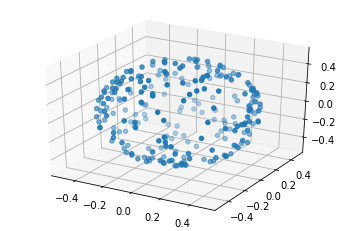

In [8]:
dots_num = 250
fig = plot.figure()
ax = plot.axes(projection='3d')
ax.scatter(*generate_sphere(dots_num))
plot.show()

### 3.2. Пример распределения точек на кубе

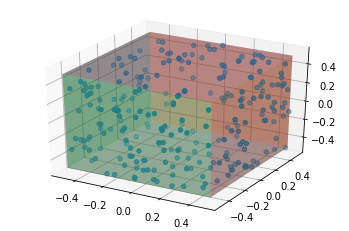

In [9]:
fig = plot.figure()
size =  0.5
ax = plot.axes(projection='3d')
ax.scatter(*generate_cube(dots_num, create_cube(size)).T.astype('f'))
for surf in create_cube(size):
    ax.plot_surface(*surf.generate_grid(), alpha = 0.35)
plot.show()

### 4. Моделирование игры

In [10]:
class Game:
    def __init__(self, dots_num, size, eps):
        self.dots_num = dots_num
        self.eps = eps
        self.size = size
        self.cube = create_cube(self.size)

    def is_point_on_sphere(self, O, r, point):
        return ((O - point) ** 2).sum() <= r ** 2

    def get_rand_point(self):
        surface = np.random.choice(self.cube)
        c = (np.random.random(size = 2) * abs(surface.const) * 2 - abs(surface.const)).tolist()
        c.insert(surface.axis, surface.const)
        return np.array(c)

    def model_game(self):
        cube_pts = generate_cube(self.dots_num, self.cube)
        p = self.get_rand_point()
        return np.apply_along_axis(lambda o: self.is_point_on_sphere(o, self.eps, p), 0, cube_pts.T).any()

    def model_game_iters(self, iters_num):
        successfull_attempts = 0
        for i in range(iters_num):
            if self.model_game():
                successfull_attempts += 1
        return successfull_attempts / iters_num

    def __str__(self):
        return "Game params:\n    dots_num: {:d},\n    size: {:.4f},\n    eps: {:.4f}".format(self.dots_num, self.size, self.eps)
        

In [11]:
game = Game(dots_num = 300, size = 0.5, eps = 0.01)
print(game)
print("Game cost:", game.model_game_iters(100))

Game params:
    dots_num: 300,
    size: 0.5000,
    eps: 0.0100
Game cost: 0.01


In [12]:
game = Game(dots_num = 300, size = 0.5, eps = 0.1)
print(game)
print("Game cost:", game.model_game_iters(100))

Game params:
    dots_num: 300,
    size: 0.5000,
    eps: 0.1000
Game cost: 0.74
